## Numerical play with bounds.

For everything in this notebook, refer back to the google doc for context. https://docs.google.com/document/d/1w2w41N5nk3-Nz9Pqfw4B1Gty_xzKy6Z-MP2bwbu0YuY/edit


Some notes
- concentration inequalities: https://en.wikipedia.org/wiki/Concentration_inequality
- Vysochanskij–Petunin_inequality: 
    - https://www.johndcook.com/blog/2016/02/12/improving-on-chebyshevs-inequality/
- learning about exponential families and sufficient statistics: https://eml.berkeley.edu/~mcfadden/e240a_sp01/sufficiency.pdf
- discrete unimodality and strong unimodality? https://www.jstor.org/stable/2283941
- strong unimodality? https://epubs.siam.org/doi/epdf/10.1137/1101021
- sum of unimodal RVs: https://math.stackexchange.com/questions/70651/is-the-sum-of-independent-unimodal-random-variables-still-unimodal


What are the different types of gradient bounds that we have available to us?
- Ignoring summation, treating the estimate as a black box with a bound on the variance of the estimate: Cantelli/Chebyshev-type concentration inequalities (e.g. Vysochanskij)
- Continuous Cauchy-Schwartz/Holder-type bounds. (ignoring summation except insofar as the Clopper-Pearson bound for the error treats it)
- Treating the summation directly via a version of the central limit theorem?
- Bounded variables can use Hoeffding or Chernoff. But we don't have bounded variables.

Quantities that are easy to get:
- unbiased estimate of T1E and its gradient
- analytical or numerical evaluation of E[d^n (theta T - A)]

## Setup

This is just a duplication of the code from the `normal_seq.ipynb` notebook.

In [70]:
import confirm.outlaw.nb_util as nb_util

nb_util.setup_nb()
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from numpy import sqrt
import jax
import jax.numpy as jnp

delta = 0.01
z_thresh = 1.96
npts = 2
a = -1
npts = 100
a = -2
b = 0
np.random.seed(9)

mu = np.linspace(a, b, 2 * npts + 1)[1::2]
stepsize = mu[1] - mu[0]

z_thresh = -jax.scipy.stats.norm.ppf(0.025)
true_err = lambda mu: 1 - jax.scipy.stats.norm.cdf(-mu + z_thresh)

# these gradients are equivalent
true_gradient = jax.vmap(jax.grad(true_err))
true_gradient2 = lambda mu: jax.scipy.stats.norm.pdf(-mu + z_thresh)
true_second = jax.vmap(jax.grad(jax.grad(true_err)))

# simulating the rejection/type I error
nsims = 100000
samples = np.random.normal(
    mu[:, None],
    1,
    size=(
        mu.shape[0],
        nsims,
    ),
)
reject = samples > z_thresh
typeI_sum = np.sum(reject, axis=-1)
typeI_est = typeI_sum / nsims

grad_est = np.sum(reject * (samples - mu[:, None]), axis=-1) / nsims

typeI_CI = scipy.stats.beta.ppf(1 - delta, typeI_sum + 1, nsims - typeI_sum) - typeI_est
chebyshev = np.sqrt(1 / (delta * nsims))
cantelli = np.sqrt(1 / nsims * (1 / delta - 1))

# the actual uniform upper bound on the second order term is ~0.2419707
# and occurs at N(x = 1, mu = 0, sig = 1) because x * np.exp(-0.5 * x ** 2) is
# maximized at x = 1
hess_bound_true = -scipy.optimize.minimize(lambda x: -true_second(x), 0).fun

# we can check the variance explicitly. note that the variance won't change
# with different values of mu because the whole integrand is just translated by
# mu.
explicit_integral = scipy.integrate.quad(
    lambda x: scipy.stats.norm.pdf(x, 0) * (x - 0) ** 2, -10, 10
)
hess_bound = explicit_integral[0]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


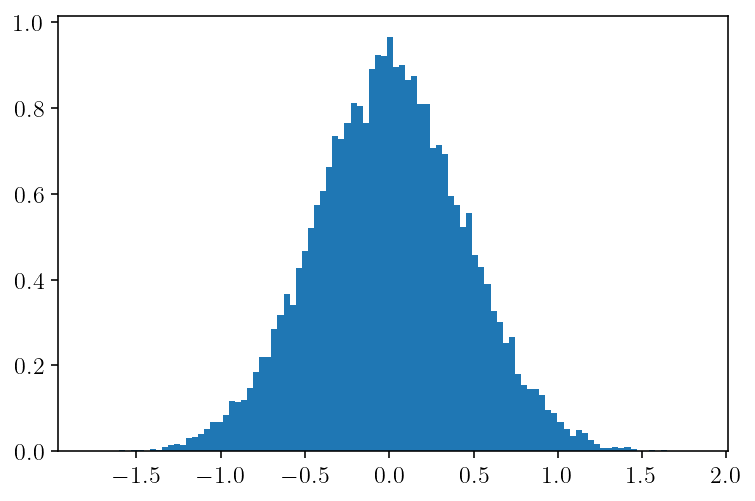

In [71]:
# Demonstration that the gradient estimate is very very close to normally distributed. CLT and all that.
more_samples = np.random.normal(
    mu[-1, None],
    1,
    size=(
        1,
        nsims,
    ),
)
plt.hist(
    np.mean(more_samples[-1, :].reshape((-1, 5)), axis=-1) - mu[-1],
    bins=100,
    density=True,
)
plt.show()

## Holder bounds

In [72]:
# egg2 = expectation of gradient of g squared.
egg2_uniform = 1.0
egg2_empirical = np.sum(reject * (samples - mu[:, None]) ** 2, axis=-1) / nsims

egg2_f = lambda mu: scipy.integrate.quad(
    lambda x: scipy.stats.norm.pdf(x, mu) * (x - mu) ** 2, z_thresh, 10
)[0]
egg2_true = np.array([egg2_f(m) for m in mu])

In [73]:
# def egQ(q):
#     I = scipy.integrate.quad(
#         lambda x: scipy.stats.norm.pdf(x, 0) * np.abs(x) ** q, -10, 10
#     )
#     print(I[1])
#     return I[0]

# For small p, q is large and we should use more precision
import mpmath as mp

mp.mp.dps = 100
gaussian_pdf = lambda x: (1 / mp.sqrt(2 * mp.pi)) * mp.exp(-(x**2) / 2)


def egQ(q):
    return float(
        mp.re(
            mp.quad(lambda x: gaussian_pdf(x) * np.abs(x) ** q, [-10, 10], error=True)[
                0
            ]
        )
    )


def qf(p):
    return 1 / (1 - 1 / p)


def holder_bound(p):
    q = qf(p)
    return ((typeI_est + typeI_CI) ** (1 / p)) * (egQ(q) ** (1 / q))


holder_bound(4)

DeviceArray([0.09032255, 0.09995196, 0.09311642, 0.08712193, 0.10187771, 0.0956109 , 0.0956109 ,
             0.09995196, 0.09787402, 0.09311642, 0.10695956, 0.10991111, 0.09787402, 0.11507972,
             0.10187771, 0.0956109 , 0.10367574, 0.11507972, 0.10991111, 0.10695956, 0.11260134,
             0.11260134, 0.1195363 , 0.12156273, 0.11260134, 0.12439878, 0.1286827 , 0.12786456,
             0.13325473, 0.13252915, 0.14282046, 0.13396721, 0.14338683, 0.14558125, 0.14663866,
             0.14449783, 0.15204789, 0.15204789, 0.15561868, 0.14966858, 0.1573082 , 0.15813126,
             0.16279935, 0.15604667, 0.16940796, 0.16426317, 0.17868411, 0.17498455, 0.17379425,
             0.17977468, 0.18418916, 0.18990021, 0.18639625, 0.18542561, 0.19190804, 0.19776333,
             0.2010676 , 0.20219401, 0.20720585, 0.20907464, 0.21186363, 0.21637163, 0.21282107,
             0.21500408, 0.223381  , 0.22283413, 0.2305093 , 0.23412511, 0.23124662, 0.24258127,
             0.23824692, 0.245

In [74]:
egQ(1.5) ** (1 / 1.5)

0.9043668487244808

In [75]:
egQ(1.01)

0.7983043178652175

In [76]:
egQ(3.0)

1.595769127497679

6.000000000000002
2.6666666666666665
1.4999999999999998


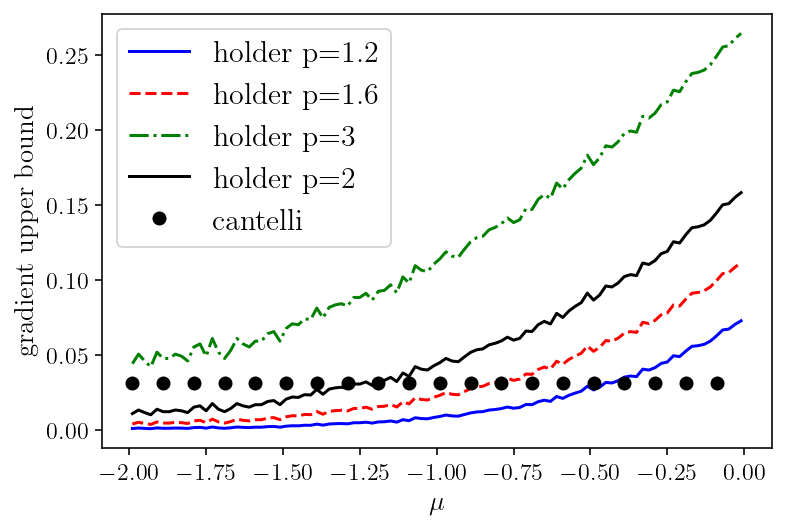

In [77]:
style = ["b-", "r--", "g-.", "k:"]
for i, p in enumerate([1.2, 1.6, 3]):
    print(qf(p))
    plt.plot(mu, holder_bound(p), style[i], label=f"holder p={p}")
plt.plot(mu, np.sqrt((typeI_est + typeI_CI) * egg2_uniform), "k-", label="holder p=2")
plt.plot(mu[::5], np.full_like(mu, cantelli)[::5], "ko", label="cantelli")
plt.xlabel("$\mu$")
plt.ylabel("gradient upper bound")
plt.legend()
plt.show()

In [78]:
[egQ(qf(p)) ** (1 / qf(p)) for p in [1.023, 1.054, 1.09, 1.2]]

[4.076545770351065, 2.7270471085677137, 2.1708321701553985, 1.57041780247502]

In [79]:
qf(1.2)

6.000000000000002

Going below p=1.2 doesn't help for this problem.

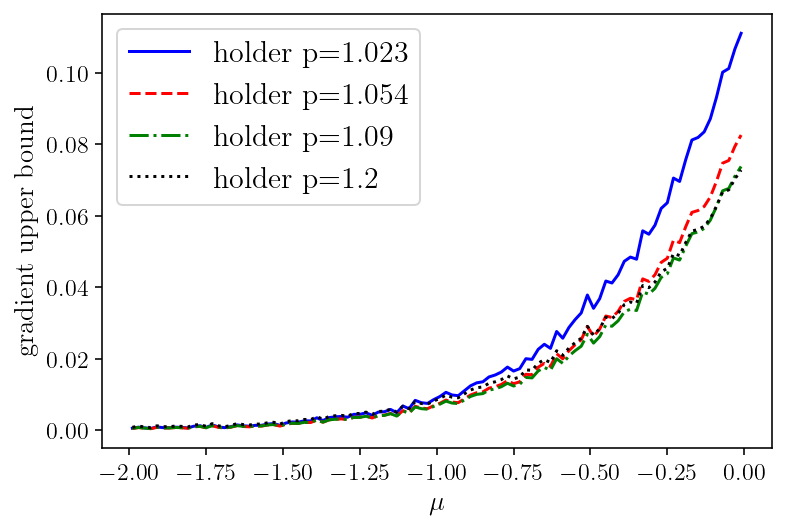

In [80]:
for i, p in enumerate([1.023, 1.054, 1.09, 1.2]):
    plt.plot(mu, holder_bound(p), style[i], label=f"holder p={p}")
plt.xlabel("$\mu$")
plt.ylabel("gradient upper bound")
plt.legend()
plt.show()

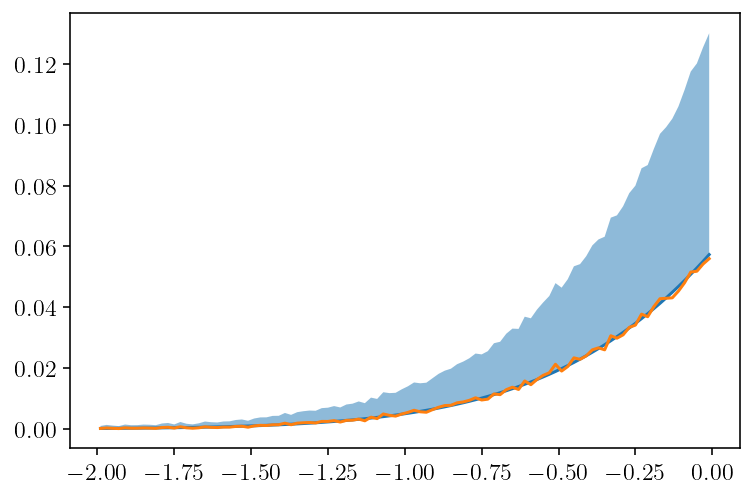

In [81]:
grad_f = lambda mu: scipy.integrate.quad(
    lambda x: scipy.stats.norm.pdf(x, mu) * (x - mu), z_thresh, 10
)[0]
grad_true = np.array([grad_f(m) for m in mu])

plt.plot(mu, grad_true, label="true")
plt.plot(mu, grad_est, label="empirical")
plt.fill_between(mu, grad_true, grad_true + holder_bound(1.2), alpha=0.5)
plt.show()

In [82]:
C = scipy.integrate.quad(
    lambda x: scipy.stats.norm.pdf(x, 0) * (x**2 + 1) ** 2, -10, 10
)[0]
C

6.000000000000001

## Solving the hessian ivp that Mike posed...

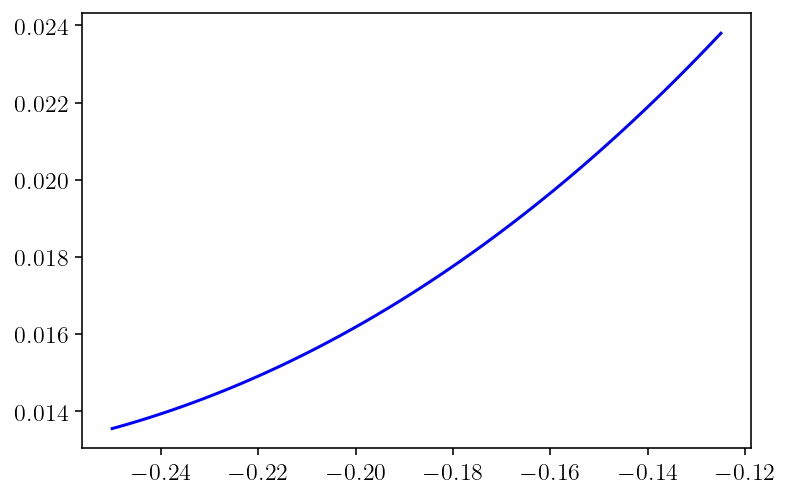

In [83]:
C = 6.0
mu = -0.25
dmu = 0.125
f0 = float(true_err(np.array([mu])))
g0 = float(true_gradient(np.array([mu])))


def f(t, y):
    return np.array([y[1], C * np.sqrt(y[0])])


mu_path = np.linspace(mu, mu + dmu, 100)
solution = scipy.integrate.solve_ivp(f, (mu, mu + dmu), [f0, g0], t_eval=mu_path)
plt.plot(mu_path, solution["y"][0, :], "b-")
plt.show()

## Cauchy-Schwartz on the third derivative

In [85]:
g = lambda t, x: t * x - t**2 / 2
dg = jax.grad(g)
ddg = jax.grad(jax.grad(g))
dddg = jax.grad(jax.grad(jax.grad(g)))
t = 0.0
C = scipy.integrate.quad(
    lambda x: scipy.stats.norm.pdf(x, 0) * (-3 * x + x**3) ** 2, -10, 10
)[0]
C

6.0

In [121]:
n = 150
p = 0.5
holderp = 3.0
holderq = qf(holderp)
At = lambda t: -n * jnp.log(
    1 - jax.scipy.special.expit(t)
)  # (t + jnp.log(1 + jnp.exp(-t)))
g = lambda t, x: t * x - At(t)
dg = jax.grad(g)
ddg = jax.grad(jax.grad(g))
dddg = jax.grad(jax.grad(jax.grad(g)))
t = scipy.special.logit(p)
integrand = lambda x, q: np.abs(
    3 * dg(t, x) * ddg(t, x) + dddg(t, x) + dg(t, x) ** 3
) ** q * scipy.stats.binom.pmf(x, n, p)
ugly = (sum([integrand(i, holderq) for i in range(n + 1)])) ** (1 / holderq)
ugly

424.33506765203475

In [122]:
holderq

1.4999999999999998

In [123]:
ugly * (0.005) ** (1 / holderp)

72.56027590164085

In [124]:
n * (1 - p) * p

37.5

In [127]:
37.5 * 0.05**2 / 2, 72.5 * 0.05**3 / 6

(0.04687500000000001, 0.001510416666666667)

## scrap

In [ ]:
# sigR2 = scipy.integrate.quad(lambda x: scipy.stats.norm.pdf(x, 0) * x ** 2, -10, 10)[0]
# rho = scipy.integrate.quad(lambda x: scipy.stats.norm.pdf(x, 0) * np.abs(x ** 3), -10, 10)[0]
# bound = 0.5 * rho / (sigR2 ** 3 * np.sqrt(nsims))
# bound

0.0252313252202016